# Tutorial: environments e learners

## Environments

Gli environments sono classi di oggetti volte a simulare 
le rewards fornite dagli utenti nell'interazione con il bandit
(ovvero acquisti o click sugli advertisement) 

Ogni environment eredita da BaseEnvironment (source/base/base_environment)
e pertanto possiede necessariamente un metodo simulate_round che prende
in input un candidato (in BaseEnvironment, questo metodo è pure virtual)

L'oggetto "environment" più semplice dopo BaseEnvironment è Environment (classe figlio, 
in source/environments/stationary/stationary_conversion_rate/environment)
che viene inizializzato con due liste di uguale lunghezza: una di candidati 
e una delle corrispondenti probabilità di conversione;
nella seguente cella di codice viene importata la classe Environment e 
creata un'istanza con quattro candidati (arms)

In [1]:
from source.environments.stationary.stationary_conversion_rate.environment import Environment
candidates = [1, 2, 3, 4]
probabilities = [.1, .2, .3, .4]
env = Environment(candidates=candidates, probabilities=probabilities)

Adesso possiamo visualizzare le probabilità associate a ciascun candidato
tramite il comando show()

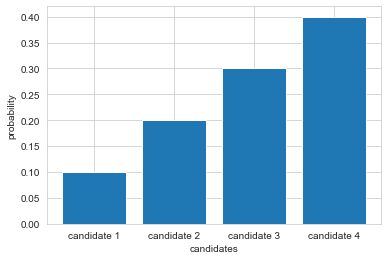

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
env.show()

Questo tipo di environment è piuttosto semplice: quando viene chiamato il comando
simulate_round(candidate=c) viene simulato il lancio di una variabile Bernoulli di
parametro uguale alla probabilità di conversione relativa al candidato c e restituito
l'esito:

In [8]:
print(
    env.simulate_round(candidate=4),
    env.simulate_round(candidate=4),
    env.simulate_round(candidate=4),
    env.simulate_round(candidate=4),
    env.simulate_round(candidate=4))

1 1 0 0 0


Esistono environment molto più complessi, la cui implementazione sfrutta l'inheritance
per garantire una interfaccia formalmente identica, riutilizzo di codice e polimorfismo.

Un esempio è il seguente environment dinamico: 
possiamo osservare che in questo environment le probabilità di ogni candidato
variano in funzione dell'istante temporale (qui le probabilità in ingresso non sono più scalari
ma callable objects)

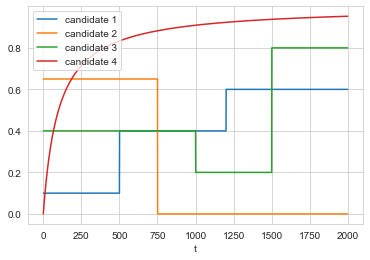

In [10]:
from source.environments.dynamic.dynamic_conversion_rate.dynamic_environment import DynamicEnvironment
def p1(t):
    if t <= 500:
        return .1
    elif t <= 1200:
        return .4
    else:
        return .6

def p2(t):
    if t <= 750:
        return .65
    else:
        return .0

def p3(t):
    if t <= 1000:
        return .4
    elif t <= 1500:
        return .2
    else:
        return .8

def p4(t):
    return t/(100 + t)

candidates = [1, 2, 3, 4]
probabilities = [p1, p2, p3, p4]
dyn = DynamicEnvironment(
    candidates=candidates, 
    probabilities=probabilities,
    horizon=2000)
dyn.show()

Le possibilità di questo approccio non si fermano qui, ma permettono - mantenendo
un'interfaccia formalmente identica - di definire environments molto più complessi,
come il prossimo environment che addirittura raccoglie diverse possibili campagne 
(ognuna descritta da un environment più semplice)

In questo caso a simulate_round verrà passata una lista di candidati (uno per campagna)
e verrà restituita una lista di rewards - tutto ciò mantenendo però una sintassi di chiamata
formalmente identica

In [12]:
from source.environments.stationary.stationary_multicampaign_environment.multicampaign_environment import MulticampaignEnvironment
budgets = [0., 1., 2., 3.]
env_c1 = Environment(candidates=budgets, probabilities=[0., .1, .3, .4])
env_c2 = Environment(candidates=budgets, probabilities=[0., .3, .2, .7])
env_c3 = Environment(candidates=budgets, probabilities=[0., .5, .5, .1])
env_c4 = Environment(candidates=budgets, probabilities=[0., .3, .1, .2])
mce = MulticampaignEnvironment(subenvironments=[env_c1, env_c2, env_c3, env_c4])

## Learners

Lo stesso tipo di gerarchia e la stessa idea di somiglianza formale è mantenuta nelle varie classi di 
learners: tutti ereditano da BaseLearner (source/base/base_learner), che però
in questo caso non è una classe pure virtual ma ha due membri (t, parametro temporale, e collected_rewards,
un numpy array che raccoglie tutte le rewards collezionate) e un metodo (update, che prende in input
un candidate e una reward e aggiorna la "logica" del learner)

Learner e environment sono classi costruite in maniera complementare, così che funzionino bene insieme:
ad ogni round, un learner seleziona un candidato da consegnare all'environment (che restituisce una reward in base
al candidato) e susseguentemente il learner viene aggiornato (sulla base del candidato selezionato e della reward ottenuta)

Il ciclo di funzionamento di qualunque learner è quindi in sostanza un ripetersi di quanto accade nella seguente
cella di codice

In [13]:
from source.learners.stationary.stationary_thompson_sampling.sts_learner import ThompsonSamplingLearner
tsl = ThompsonSamplingLearner(candidates=candidates)
arm = tsl.select_arm()
reward = env.simulate_round(arm)
tsl.update(arm, reward)

Esattamente come per gli environment, i learner - pur mantenendo questa semplice interfaccia - possono avere 
internamente i funzionamenti più complicati, come accade per i learners nella seguente cella:
l'uno ad ogni iterazione fitta una regressione gaussiana per la conversion rate, l'altro ammette un numero arbitrario di 
altri learners (è il diretto corrispondente del MulticampaignEnvironment)

In [14]:
from source.learners.stationary.gaussian_thompson_sampling.gpts_learner import GaussianProcessThompsonSamplingLearner
from source.learners.stationary.budget_combinatorial_learner.budget_combinatorial_learner import BudgetCombinatorialLearner
gpl = GaussianProcessThompsonSamplingLearner(candidates=budgets, sigma=1, theta=1, lenscale=1)
bcl = BudgetCombinatorialLearner(budgets=budgets, subcampaign_learner=gpl, n_campaigns=4)

## Simulations e Testers
Perché mantenere la stessa interfaccia per casistiche così disparate? 
Perché così possiamo definire una volta e per tutte dei "simulatori" per gestire l'interazione di learner ed environment
e di "test" per ripetere le simulazioni diverse volte a partire dalla stessa configurazione iniziale, come si vede 
nella seguente cella di codice


>> running simulations...running simulations (experiment 1 of 2000)...running simulations (experiment 2 of 2000)...running simulations (experiment 3 of 2000)...running simulations (experiment 4 of 2000)...running simulations (experiment 5 of 2000)...running simulations (experiment 6 of 2000)...running simulations (experiment 7 of 2000)...running simulations (experiment 8 of 2000)...running simulations (experiment 9 of 2000)...running simulations (experiment 10 of 2000)...running simulations (experiment 11 of 2000)...

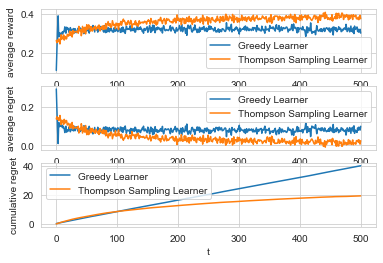

In [23]:
from source.learners.stationary.greedy.greedy_learner import GreedyLearner
from source.testing.tester import Tester
candidates = [1, 2, 3, 4]
probabilities = [.1, .2, .3, .4]
env = Environment(candidates=candidates, probabilities=probabilities)
tsl = ThompsonSamplingLearner(candidates=candidates)
grl = GreedyLearner(candidates=candidates)
test = Tester(
        environment=env,
        learners=(grl, tsl),
        optimal_expected_reward=.4,
        exploration_horizon=500,
        experiments=2000)
test.run()
test.show_results()

Rispettando la struttura base di learners ed environment, la classe test funziona correttamente anche in caso di 
non-stazionarità e funzionamenti interni molto complessi


